# SIMEX notebook to demonstrate setting up a Gaussian wavefront using the SimEx Calculator "GaussPhotonSource".

In this notebook, we will demonstrate how to propagate a simple Gaussian wavefront between two planes through vacuum. This is the simplest case of coherent wavefront propagation.

In [7]:
# Import all SimEx modules
from SimEx.Calculators.WavePropagator import WavePropagator
from SimEx.Calculators.GaussianPhotonSource import GaussianPhotonSource
from SimEx.Parameters.WavePropagatorParameters import WavePropagatorParameters
from SimEx.Parameters.GaussWavefrontParameters import GaussWavefrontParameters

from SimEx.Utilities.Units import electronvolt, meter, joule, radian
import numpy

### Setup the initial wavefront
We first create a wavefront with a Gaussian intensity distribution. To this end, we use the `GaussianPhotonSource` Calculator and it's corresponding parameter, the `GaussWavefrontParameters`.

We first describe the wavefront parameters which will then be used to create the wavefront itself:

In [8]:
wavefront_parameters = GaussWavefrontParameters(photon_energy=8.0e3*electronvolt,
                                                photon_energy_relative_bandwidth=1e-3,
                                                beam_diameter_fwhm=1.0e-4*meter,
                                                pulse_energy=2.0e-6*joule,
                                                number_of_transverse_grid_points=400,
                                                number_of_time_slices=12,
                                                z=100*meter,
                                                )

The parameters of the wavefront constructor are self explaining. Note that $z$, the longitudinal wavefront coordinate is set to $100$ m, i.e. far enough
away from the source position to justify a far-field treatment.

Now, we use these`wavefront_parameters` to initialize the Photon Source.

In [25]:
photon_source = GaussianPhotonSource(wavefront_parameters, input_path="/dev/null", output_path="initial_wavefront.h5")

Let's calculate the initial wavefront and visualize it. Running the `backengine` method of `photon_source`, initializes the data fields and returns the Rayleigh length.

In [26]:
photon_source.backengine()

146.22875114783653


We can retrieve the wavefront data from the calculator:

In [27]:
wavefront = photon_source.data

Let's visualize the wavefront using the WPG utilities.

In [28]:
from wpg import wpg_uti_wf as wpg_utils

First plot the intensity distribution

R-space
(400,) (400,)
FWHM in x = 1.147e-04 m.
FWHM in y = 1.147e-04 m.


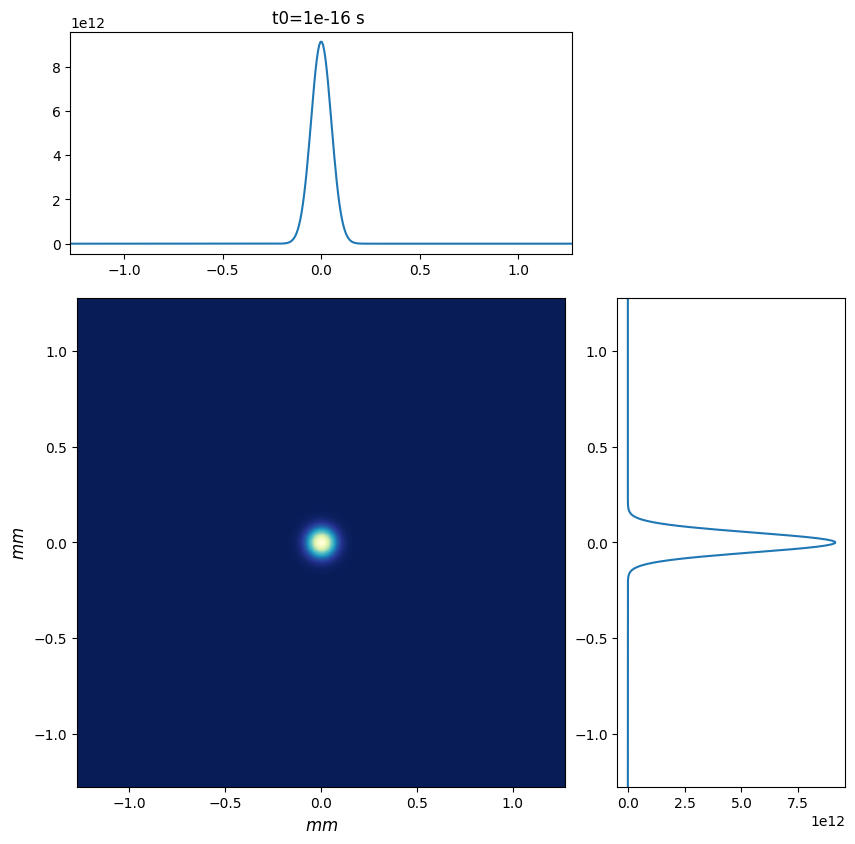

In [56]:
wpg_utils.plot_intensity_map(wavefront)

## Plot intensity distribution in q-space
Then, plot the intensity profile in reciprocal ($q$-)space.

Q-space
{'fwhm_x': 6.657123479604694e-07, 'fwhm_y': 6.657123479604694e-07}
Q-space
(400,) (400,)


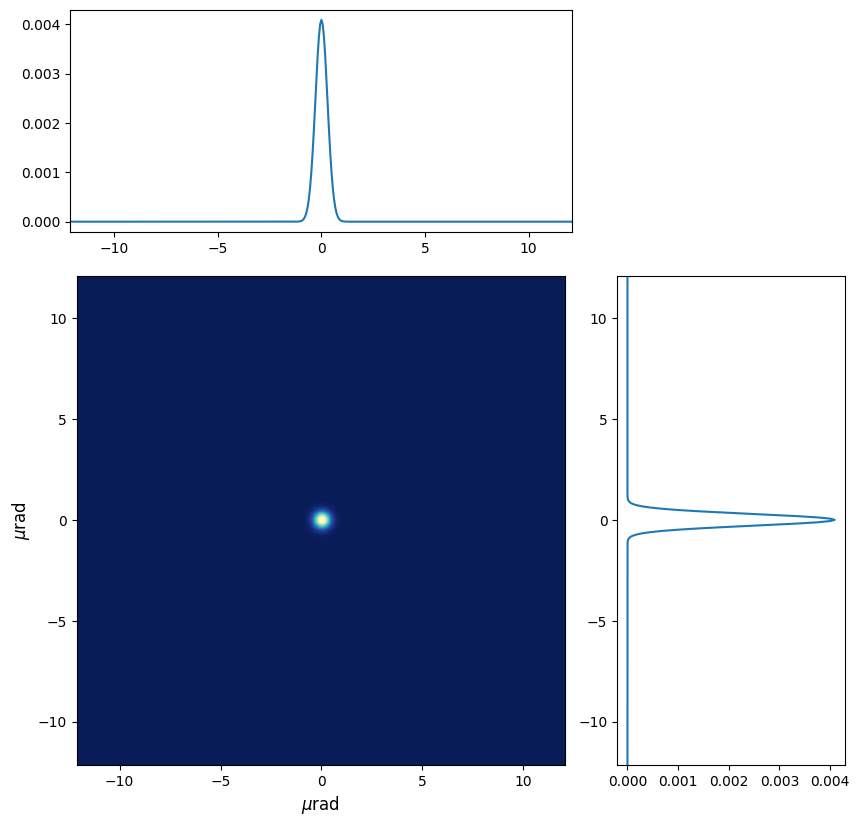

In [12]:
wpg_utils.plot_intensity_qmap(wavefront)

Next, plot the power as a function of time integrated over the transverse dimensions.

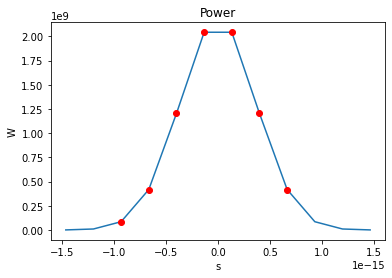

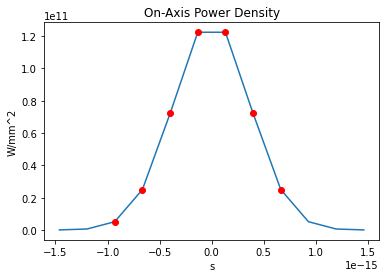

number of meaningful slices: 7
Pulse energy 2e-06 J


1059337216.0

In [13]:

wpg_utils.integral_intensity(wavefront)

Finally, we check the sampling quality.

In [15]:
print(wpg_utils.check_sampling(wavefront))

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|1.147e-04|6.386e-06|2.548e-03|1.772e+02|1.196e-04|4.470e-05|6.386e-05|
|Vertical  |1.147e-04|6.386e-06|2.548e-03|1.772e+02|1.196e-04|4.470e-05|6.386e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


The wavefront quality report is somewhat suboptimal because the Fresnel zone extension is below the recommended minimimum of 7 times the sampling (pixel) size. We will proceed anyway and check after propagation if this is a problem.

Our next step is to propagate the wavefront through 100 m of empty space. Let's estimate the beam size using the beam waist formula.

The beam waist size (rms width of the E-field distribution, or distance from beam axis where intensity drops to $1/e^2$ of its on-axis value) is given by the expression

$ w(z) = w_0 \sqrt{1 + \left(\frac{z}{R}\right)^2}$, with the Rayleigh length $R = \frac{\pi w_0^2}{\lambda}$, $\lambda$ is the central wavelength of the laser (ca,. 0.15 nm at 8 keV.)

Our Gaussian source distribution has a FWHM of $10^{-4} m$. The FWHM and the beam waist radius as defined above are related to each other through $\mathrm{FWHM}(z) = \sqrt{2 \ln 2} w(z) \simeq 1.177 w(z)$


Beam waist at z=0: $w_0 = 100\,\mathrm{\mu m} / 1.177 \simeq 84.9\,\mathrm{\mu m}$.  
The Rayleigh length for our Gaussian beam is $R = \frac{\pi w_0^2}{0.15 \mathrm{nm}} \simeq 151\,\mathrm{m}$.

At $z=100\,\mathrm{m}$, we therefore expect a FWHM of $100\,\mu\mathrm{m}\cdot\sqrt{1.+\left(100/151\right)^2} \simeq 119.9 \mu\mathrm{m}$.

## Setup the beamline
We are now ready to specify the beamline. Import the corresponding classes,

In [30]:
from wpg import Beamline, optical_elements, srwlib


And initialize

In [33]:
beamline = Beamline()
free_space = optical_elements.Drift(_L=99, _treat=1)
free_space_propagation_parameters = optical_elements.Use_PP(semi_analytical_treatment=1)

Finaly, assemble the beamline

In [34]:
beamline.append(free_space, free_space_propagation_parameters)

To start the propagation, we transform the wavefront to frequency space, run the beamline's `.propagate()` method and backtransform to temporal representation.

In [26]:
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 'f')
beamline.propagate(wavefront)
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 't')

The wavefront has now been propagated through the beamline. As above, we can 
visualize the intensity profiles in various projections and Fourier components:

### Real space transverse intensity profile:

R-space
(400,) (400,)
FWHM in x = 1.282e-04 m.
FWHM in y = 1.282e-04 m.


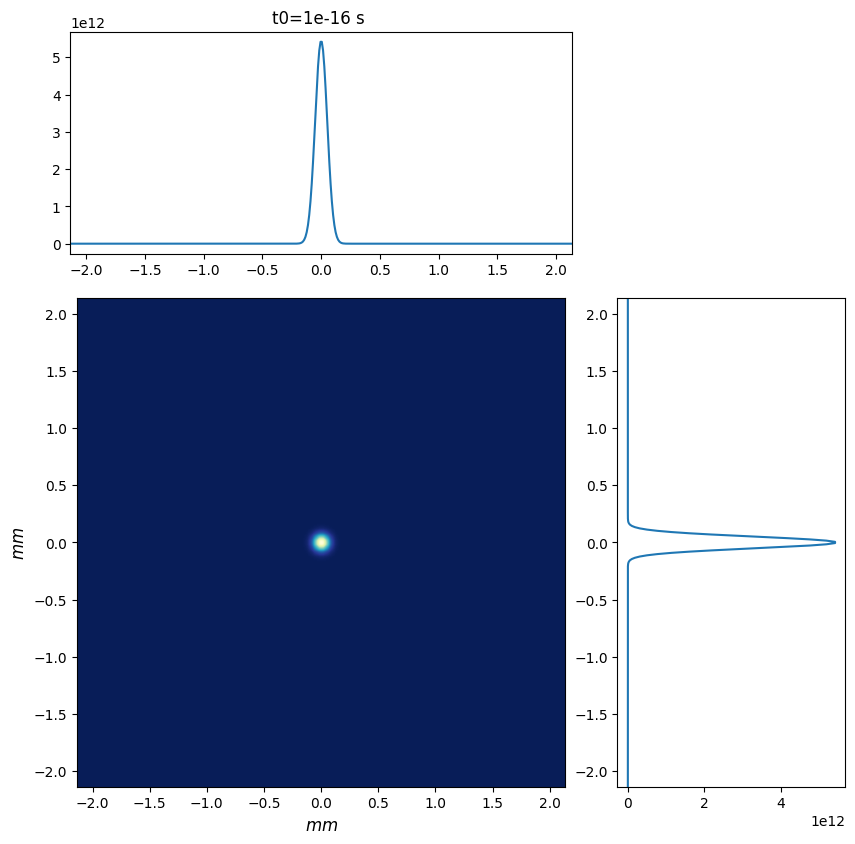

In [21]:
wpg_utils.plot_intensity_map(wavefront)

The propagated wavefront has a  $\mathrm{FWHM} = 128.2\,\mathrm{\mu m}$. Considering that the FWHM is measured by counting pixels in the intensity profile, this is in rather good agreement with the analytical calculation above which yielded $119\,\mathrm{\mu m}$.

## Exercises: Calculate the FWHM of the central diffraction peak and the position of the first diffraction side maximum. Compare your results with the simulated experiment. 
### Pinhole of size 50 $\mu$m.
### Pinhole of size 10 $\mu$m.
### Circular disk of 50 $\mu$m.
### Circular disk of 10 $\mu$m.
### Confirm Babinet's principle. Calculate the ratio of integrated intensities between diffraction from an aperture and from the circular disk.